In [ ]:
# Mounting Google Drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
%cd /content

/content


In [1]:
holly_face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/archive.zip'


face_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/dataset2/'

VM_path = '/content'
drive_path = '/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/'
VM_face_path = '/content/dataset2'
VM_face_aug_path = '/content/dataset'
face_detection_path= "/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"
proto_path = "/content/drive/MyDrive/Colab Notebooks/ProjectData/FaceRecognition/face_detection_model/deploy.prototxt"

In [2]:
!cp '{holly_face_path}' '/content'

In [3]:
!unzip -q /content/archive.zip -d /content

In [4]:
#!cp -r '{face_path}' '{VM_path}'

In [5]:
#run this if you want to save augmented images
!mkdir /content/dataset

In [ ]:
# run this to clear all in dataset folder
!rm -r /content/dataset/*

rm: cannot remove '/content/dataset/*': No such file or directory


In [ ]:
# run this if you want to save face roi
!mkdir /content/dataset2

In [ ]:
#run this to clear all in dataset2 folder
!rm -r /content/dataset2/*

rm: cannot remove '/content/dataset2/*': No such file or directory


In [ ]:
%ls /content/dataset/

In [11]:
# Always run this
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow
import pickle
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [ ]:
# run this if do not have the face roi. What this code does if if produces 5 augmentaions for each image in the dataset
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest')

image_size = 224
NUMBER_TO_AUGMENT = 5
c = 0
labelConverter = {}
dirpath = face_path
paths = os.listdir(dirpath)
#known_face = []
 
for directory in paths:
    !mkdir '/content/dataset/{directory}'
    labelConverter[directory] = c
    c+=1
print(labelConverter)
for p in paths:
    label = labelConverter[p]
    aug_save_path = VM_face_aug_path+'/'+p
    for p1 in os.listdir(dirpath+'/'+p):
      num_aug = 0
      try:
          path = dirpath+'/'+p+'/'+p1
          img = cv2.imread(path)
          #img = cv2.resize(img,(image_size, image_size))
          img_np = np.asarray(img)
          img_np = np.expand_dims(img_np,0)
          print("Image size = ",img_np.shape)
          it = datagen.flow(img_np, batch_size=1, save_to_dir=aug_save_path, save_prefix='celeb', save_format='png')
          while  num_aug < NUMBER_TO_AUGMENT:
            it.next()
            print(num_aug+1,'th augmenatation of',path)
            num_aug += 1
      except Exception as e:
          print("Error",e)




In [ ]:
# this uploads the augmented dataset from VM to drive
!cp -r '{VM_face_aug_path}' '/content/drive/MyDrive/'

In [ ]:
# Run This if you need Face detector
print("Loading face detector.....")
detector = cv2.dnn.readNetFromCaffe(proto_path, face_detection_path)

In [ ]:
# run this if you need Haar Face detector
face_dec = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [ ]:
# run this if you need DNN Face detector
def getFace_CV2DNN(image):
  (h,w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)),1.0, (300,300),(104.0, 177.0, 123.0), swapRB= False, crop = False)
  detector.setInput(blob)
  detections = detector.forward()
  max = -1
  fHM = 0
  fWM = 0
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  for i in range(0,detections.shape[2]):
    confidence = detections[0,0,i,2];
    
    if confidence < 0.7:
      continue

    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    cv2.rectangle(image, (startX, startY), (endX, endY), (0,0,255), 2)
    
    
    fH = endX - startX
    fW = endY - startY
    #print("ggg-",fW,fH)
    if fH < 20 or fW < 20:
      continue
    area = fH*fW
    if max < area:
      max = area
      x1 = startX
      x2 = endX
      y1 = startY
      y2 = endY
  return x1,x2,y1,y2


In [ ]:
# run this if you need Haar Face detector
def getFace_haar(image):
  max = -1
  x1 = 0
  x2=0
  y1=0
  y2 = 0
  faces = face_dec.detectMultiScale(image, 1.3,5)
  for (x,y,w,h) in faces:
    #print(w,h)
    if w < 20 or h <20:
      continue
    area = h*w
    if max < area:
      max = area
      x1 = x
      y1 = y
      x2 = x+w
      y2 = y+h

    return x1, x2, y1, y2
    

In [ ]:
# Run this if you want to get face_roi from augmented images  
#knownface = []
count = 0
k = 1
facelabels = os.listdir(VM_face_aug_path)
for f in facelabels:
  sorc = VM_face_aug_path+'/'+f
  dest = VM_face_path+'/'+f
  os.mkdir(dest)
  img_list = os.listdir(sorc)
  print('Processing ',f, str(k), 'out of ', str(len(facelabels)), 'classes')
  k += 1
  for img in img_list:
    imgPath = sorc+'/'+img
    image = cv2.imread(imgPath)
    #faces = face_dec.detectMultiScale(image)
    print(image.shape)
    cord = getFace_CV2DNN(image)
    if cord == None:
      continue
    x1,x2, y1, y2 = cord
    try:
      image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      face = image[y1:y2, x1:x2]
      
      savepath = dest+'/'+str(count)+'.png'
      count += 1
      
      cv2.imwrite(savepath, face)
    except Exception as e:
      print('Error: ',e) 

In [ ]:
# run this if ypou want to upload the face_roi from VM to google drive 
%cp -r '/content/dataset2' '/content/drive/MyDrive'

In [ ]:
# run this if you want to download the face_roi from google drive to VM
!cp -r '/content/drive/MyDrive/dataset2' '/content'

In [6]:
!ls -la /content/105_classes_pins_dataset/

total 1176
drwxr-xr-x 107 root root  4096 May 28 06:21  .
drwxr-xr-x   1 root root  4096 May 28 06:21  ..
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Adriana Lima'
drwxr-xr-x   2 root root 16384 May 28 06:21 'pins_Alexandra Daddario'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Alex Lawther'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Alvaro Morte'
drwxr-xr-x   2 root root 16384 May 28 06:21 'pins_alycia dabnem carey'
drwxr-xr-x   2 root root  4096 May 28 06:21 'pins_Amanda Crew'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_amber heard'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Andy Samberg'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Anne Hathaway'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Anthony Mackie'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_Avril Lavigne'
drwxr-xr-x   2 root root  4096 May 28 06:21 'pins_barack obama'
drwxr-xr-x   2 root root 12288 May 28 06:21 'pins_barbara palvin'
drwxr-xr-x   2 root root  4096 May 28 06:21 '

In [7]:
!rm -r /content/dataset/.ipynb_checkpoints

rm: cannot remove '/content/dataset/.ipynb_checkpoints': No such file or directory


In [12]:
# set the dataset on which you want to train
train_path1 = '/content/105_classes_pins_dataset/'
train_path = '/content/dataset'

In [13]:
count = 0
NB_CLASS = 20
l = os.listdir(train_path1)
for li in l:
  count += 1
  sor = '"105_classes_pins_dataset/'+li+'"'
  dest = 'dataset'
  cmd = 'cp -r '+ sor+' '+ dest
  cmd1 = 'rm -r'+ sor
  os.system(cmd)
  os.system(cmd1)
  if count >= NB_CLASS:
    break


In [14]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest')
NUM_AUG = 1
knownface = []
labels = []
labelEncoder = {}
count = 0
c = 0
dir = '/content/dataset/'
'''
for d in os.listdir(dir):
  labelEncoder[count] = d
  print('Processig for ....',d)
  for k in os.listdir(dir+d):
    image = cv2.imread(dir+d+'/'+k)
    img_np = np.asarray(image)
    img_np = img_np[np.newaxis,:,:,:]

    for im in datagen.flow(img_np, batch_size=1):
      imnp = cv2.resize(im[0], (224,224))
      
      knownface.append(imnp)
      labels.append(count)
      c+=1
      if c >= NUM_AUG:
        break
    c = 0
  count += 1 
'''
for d in os.listdir(dir):
  labelEncoder[count] = d
  print('Processig for ....',d)
  for k in os.listdir(dir+d):
    image = cv2.imread(dir+d+'/'+k)
    #img_np = np.asarray(image)
    imnp = cv2.resize(image, (224,224))
    knownface.append(imnp)
    labels.append(count)
    count += 1 



Processig for .... pins_Miley Cyrus
Processig for .... pins_Emilia Clarke
Processig for .... pins_Rebecca Ferguson
Processig for .... pins_Millie Bobby Brown
Processig for .... pins_grant gustin
Processig for .... pins_Mark Zuckerberg
Processig for .... pins_amber heard
Processig for .... pins_Neil Patrick Harris
Processig for .... pins_Bill Gates
Processig for .... pins_Krysten Ritter
Processig for .... pins_Brenton Thwaites
Processig for .... pins_Alexandra Daddario
Processig for .... pins_Taylor Swift
Processig for .... pins_Stephen Amell
Processig for .... pins_Madelaine Petsch
Processig for .... pins_Jeremy Renner
Processig for .... pins_Katherine Langford
Processig for .... pins_Jennifer Lawrence
Processig for .... pins_Anne Hathaway
Processig for .... pins_Zoe Saldana


In [15]:
X = np.array(knownface)
y = np.array(labels)
num_classes = len(labelEncoder)

In [16]:
labelEncoder

{0: 'pins_Miley Cyrus',
 1: 'pins_Emilia Clarke',
 2: 'pins_Rebecca Ferguson',
 3: 'pins_Millie Bobby Brown',
 4: 'pins_grant gustin',
 5: 'pins_Mark Zuckerberg',
 6: 'pins_amber heard',
 7: 'pins_Neil Patrick Harris',
 8: 'pins_Bill Gates',
 9: 'pins_Krysten Ritter',
 10: 'pins_Brenton Thwaites',
 11: 'pins_Alexandra Daddario',
 12: 'pins_Taylor Swift',
 13: 'pins_Stephen Amell',
 14: 'pins_Madelaine Petsch',
 15: 'pins_Jeremy Renner',
 16: 'pins_Katherine Langford',
 17: 'pins_Jennifer Lawrence',
 18: 'pins_Anne Hathaway',
 19: 'pins_Zoe Saldana'}

In [17]:
print(len(knownface))

3540


In [18]:
X_1, X_test, y_1, y_test = train_test_split( X, y, shuffle=True,random_state = 100,test_size=0.2,stratify=y)

In [19]:
X_train, X_val, y_train, y_val = train_test_split( X_1, y_1,shuffle=True,random_state = 100,test_size=0.25,stratify=y_1)

(array([77., 73., 56., 66., 59., 87., 58., 73., 81., 78.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

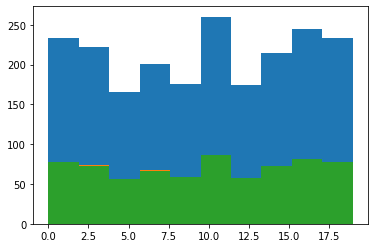

In [20]:
plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_val)

In [21]:
print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)


(708, 224, 224, 3)
(708, 224, 224, 3)
(2124, 224, 224, 3)


In [22]:

from keras.preprocessing.image import ImageDataGenerator
'''
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   brightness_range = [0.5,1.5],
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='training')

testing_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical', 
                                                 subset='validation')


'''

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   brightness_range = [0.5,1.5])

training_set = train_datagen.flow(x = X_train,y = y_train,batch_size = 32)

testing_set = train_datagen.flow(x = X_test,y= y_test,batch_size = 32)

validation_set = train_datagen.flow(x= X_val, y = y_val, batch_size=32)



In [23]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of VGG
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg = InceptionV3(include_top=False,weights='imagenet', input_shape=(224,224,3))

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# useful for getting number of classes
folders = glob(train_path+'/*')
  
print("Number of classes = ", len(folders))
  

87924736/87910968 [==============================] - 1s 0us/step
Number of classes =  20


In [24]:
unfrozen_layer = -43 # InceptionV3
#unfrozen_layer = -1 # VGG16
for l in vgg.layers[unfrozen_layer:]:
  l.trainable = True
vgg.summary()
for l in vgg.layers:
  print(l, l.trainable)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [25]:
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:


drive_path_checkpoint = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/checkpoint/holly_Inception_3.hdf5'
model_checkpoint = ModelCheckpoint(
    filepath=drive_path_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, save_freq='epoch')




In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()]
)

In [28]:
r = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=32,
  callbacks = [model_checkpoint]
)

Epoch 1/32
67/67 [==============================] - 101s 600ms/step - loss: 8.7711 - accuracy: 0.0824 - precision: 0.0537 - recall: 0.0292 - val_loss: 2.4330 - val_accuracy: 0.2218 - val_precision: 0.1335 - val_recall: 0.0206
Epoch 2/32
67/67 [==============================] - 32s 482ms/step - loss: 2.1482 - accuracy: 0.2916 - precision: 0.2162 - recall: 0.0290 - val_loss: 1.8110 - val_accuracy: 0.4167 - val_precision: 0.4251 - val_recall: 0.0647
Epoch 3/32
67/67 [==============================] - 32s 484ms/step - loss: 1.6199 - accuracy: 0.4596 - precision: 0.4962 - recall: 0.0870 - val_loss: 2.2325 - val_accuracy: 0.3884 - val_precision: 0.5689 - val_recall: 0.1354
Epoch 4/32
67/67 [==============================] - 32s 475ms/step - loss: 1.4894 - accuracy: 0.5276 - precision: 0.5760 - recall: 0.1534 - val_loss: 1.5912 - val_accuracy: 0.5099 - val_precision: 0.6220 - val_recall: 0.1956
Epoch 5/32
67/67 [==============================] - 32s 479ms/step - loss: 1.1887 - accuracy: 0.611

In [29]:
model_path = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/pickle/transferInception_holly_3_dataset.h5'
model.save(model_path)

In [30]:
preds = model.evaluate(validation_set)


23/23 [==============================] - 9s 397ms/step - loss: 1.6909 - accuracy: 0.6243 - precision: 0.8280 - recall: 0.6842


In [31]:
test_loss,test_accuracy, test_precision, test_recall = preds
print("Test Loss = ", test_loss)
print("Test Accuracy", test_accuracy)
print("Test Precision", test_precision)
print("Test Recall", test_recall)

Test Loss =  1.6908658742904663
Test Accuracy 0.6242938041687012
Test Precision 0.8279895782470703
Test Recall 0.6841931343078613


In [32]:
NB_EPOCHS = 32
#np.abs(np.subtract(val_loss_trace,loss_trace))
m = []
for i in range(1,NB_EPOCHS+1):
  m.append(i)

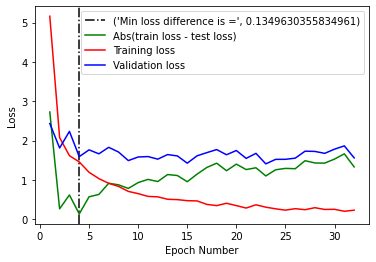

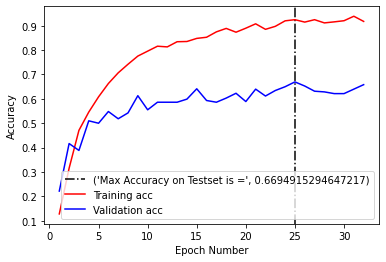

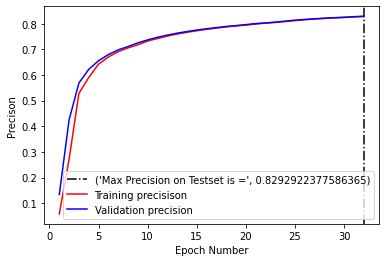

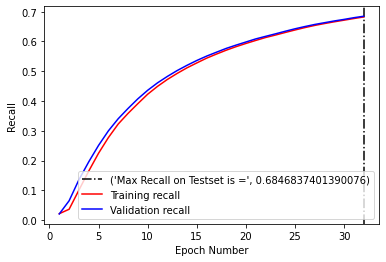

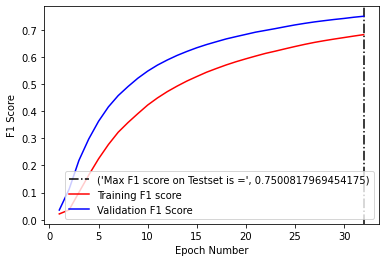

In [36]:
plot_save = '/content/drive/My Drive/Colab Notebooks/ProjectData/FaceRecognition/plots/holly_test_train_split(checkpoint_holly_Inception_3)/'


loss_trace = r.history['loss']
val_loss_trace = r.history['val_loss']
delta = np.abs(np.subtract(val_loss_trace,loss_trace))
min_lo = np.argmin(delta) +1# +1 because the indexing starts from 1
plt.axvline(x=min_lo,c = 'k', linestyle='-.')
s = 'Min loss difference is =',delta[min_lo-1]

plt.plot(m,delta, c = 'g')
plt.plot(m,loss_trace, c='r')
plt.plot(m,val_loss_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend([s,'Abs(train loss - test loss)','Training loss', 'Validation loss'], loc='upper right')
plt.savefig(plot_save+'loss.png')
plt.show()



accuracy_trace = r.history['accuracy']
val_accuracy_trace = r.history['val_accuracy']

max_acc = np.argmax(val_accuracy_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_acc,c = 'k', linestyle='-.')
s0 = 'Max Accuracy on Testset is =',val_accuracy_trace[max_acc-1]

plt.plot(m,accuracy_trace, c='r')
plt.plot(m,val_accuracy_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend([s0,'Training acc', 'Validation acc'], loc='lower right')
plt.savefig(plot_save+'acc.png')
plt.show()


precision_trace = r.history['precision']
val_precision_trace = r.history['val_precision']

max_pre = np.argmax(val_precision_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_pre,c = 'k', linestyle='-.')
s1 = 'Max Precision on Testset is =',val_precision_trace[max_pre-1]

plt.plot(m,precision_trace, c='r')
plt.plot(m,val_precision_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Precison')
plt.legend([s1,'Training precisison', 'Validation precision'], loc='lower right')
plt.savefig(plot_save+'pre.png')
plt.show()



recall_trace = r.history['recall']
val_recall_trace = r.history['val_recall']


max_recall = np.argmax(val_recall_trace) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_recall,c = 'k', linestyle='-.')
s2 = 'Max Recall on Testset is =',val_recall_trace[max_recall-1]


plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('Recall')
plt.legend([s2,'Training recall', 'Validation recall'], loc='lower right')
plt.savefig(plot_save+'recall.png')
plt.show()


f1_score = 2*(np.multiply(precision_trace , recall_trace))/(np.add(precision_trace ,recall_trace))
val_f1_score = 2*(np.multiply(val_precision_trace , val_recall_trace))/(np.add(val_precision_trace ,val_recall_trace))

f1_trace = f1_score
val_recall_trace = val_f1_score

max_f1 = np.argmax(val_f1_score) +1 # +1 because the indexing starts from 1
plt.axvline(x=max_f1,c = 'k', linestyle='-.')
s3 = 'Max F1 score on Testset is =',val_f1_score[max_f1-1]

plt.plot(m,recall_trace, c='r')
plt.plot(m,val_recall_trace, c='b')
plt.xlabel('Epoch Number')
plt.ylabel('F1 Score')
plt.legend([s3, 'Training F1 score', 'Validation F1 Score'], loc='lower right')
plt.savefig(plot_save+'f1.png')
plt.show()
